In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

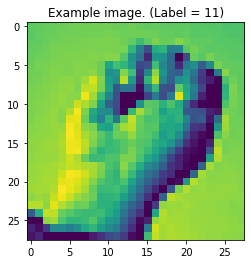

In [3]:
# Load training data
data = pd.read_csv('sign_mnist_train.csv').to_numpy()

# constants
IMG_SIZE = (28, 28, 1)
NUM_DATA = len(data)
SPLIT_THRESH = 0.8
NUM_CLASSES = 25

# create training and validation data
n = int(SPLIT_THRESH * NUM_DATA)
X, y = data[:,1:].reshape(NUM_DATA, 28, 28), data[:,0]
X = np.expand_dims(X, 3)
X = X / 127.5 - 1
y[y > 9] -= 1

# Load testing data
test_data = pd.read_csv('sign_mnist_test.csv').to_numpy()
NUM_TEST = len(test_data)
X_test, y_test = test_data[:,1:].reshape(NUM_TEST, 28, 28), test_data[:,0]
X_test = np.expand_dims(X_test, 3)
# X_test = X_test / 127.5 - 1
y_test[y_test > 9] -= 1

# Show example
example_idx = 100
plt.imshow(X[example_idx])
plt.title('Example image. (Label = {lbl})'.format(lbl=y[example_idx]))
plt.show()

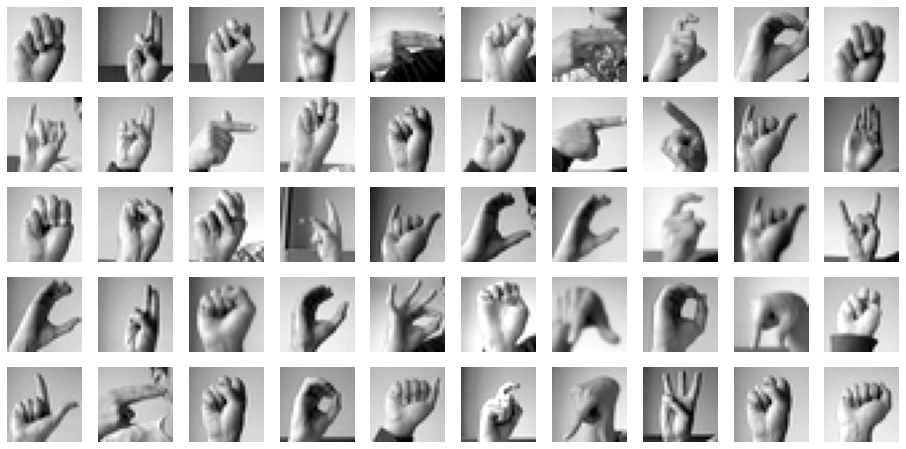

In [4]:
def vis(X, n):
    fig=plt.figure(figsize=(16, 8))
    columns = 10
    rows = 5
    for i in range(1, columns*rows +1):
        idx = np.random.randint(n)
        img = X[idx]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()
    
vis(X, NUM_DATA)

Found 7200 files belonging to 24 classes.


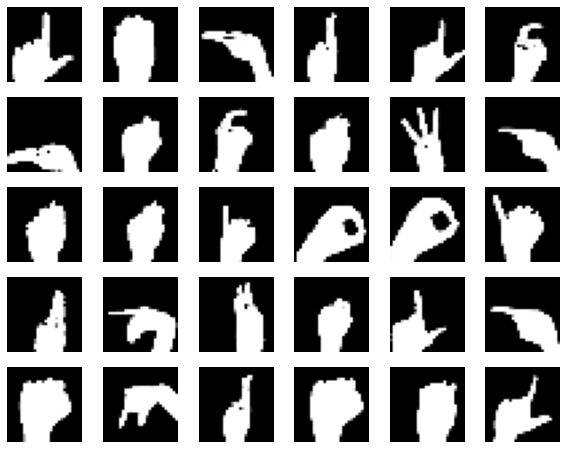

In [5]:
IMAGE_SIZE = 28
def getDataset(path):
    return tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels='inferred',
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        color_mode='grayscale',
        interpolation='gaussian'
    )

# Construct the Columbia datasets
data = getDataset('./created_dataset')

test = data.take(1).__iter__().get_next()[0]
fig=plt.figure(figsize=(10, 8))
columns = 6
rows = 5
for i in range(1, columns*rows +1):
    img = test[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



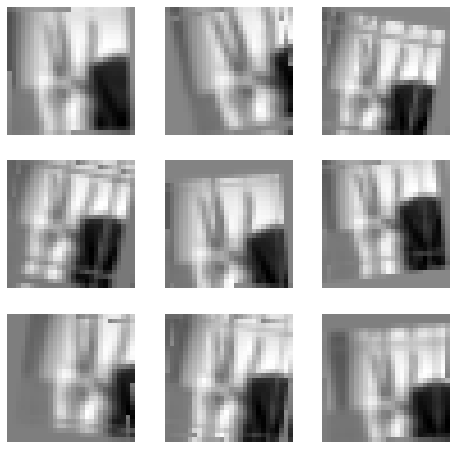

In [6]:
import tensorflow.keras.layers as layers

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.5),
    tf.keras.layers.experimental.preprocessing.RandomZoom((0, 0.5)),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.15, 0.15, fill_mode='constant'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05),
])

# Add the image to a batch
image = X[200]
image = tf.expand_dims(image, 0)

plt.figure(figsize=(8, 8))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0], cmap='gray')
    plt.axis("off")

In [7]:
# LeNet architecture
layers = [
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.5, input_shape=(28,28,1)),
    tf.keras.layers.experimental.preprocessing.RandomZoom((0, 0.3)),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.15, 0.15, fill_mode='constant'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05),
    
    tf.keras.layers.Conv2D(32, 5, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Conv2D(32, 5, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(24, activation='softmax')
]
model = tf.keras.models.Sequential(layers)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast_1 (RandomCon (None, 28, 28, 1)         0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 28, 28, 1)         0         
_________________________________________________________________
random_translation_1 (Random (None, 28, 28, 1)         0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 32)       

In [8]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

# Expect a loss of -log(1/24) = 3.17
model.evaluate(X, y, steps=10)

history = model.fit(X, y, epochs=30, batch_size=64, validation_split=0.2, 
                    callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler)])

10/10 [==============================] - 7s 729ms/step - loss: 3.1792 - sparse_categorical_accuracy: 0.0465
Epoch 1/30
 57/344 [===>..........................] - ETA: 46s - loss: 3.3118 - sparse_categorical_accuracy: 0.1209ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/home/khatna/Code/SeniorYear/COS429/Project/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-2761ca293c0c>", line 10, in <module>
    history = model.fit(X, y, epochs=30, batch_size=64, validation_split=0.2,
  File "/home/khatna/Code/SeniorYear/COS429/Project/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py", line 108, in _method_wrapper
    return method(self, *args, **k

TypeError: object of type 'NoneType' has no len()

In [ ]:
model.evaluate(data)

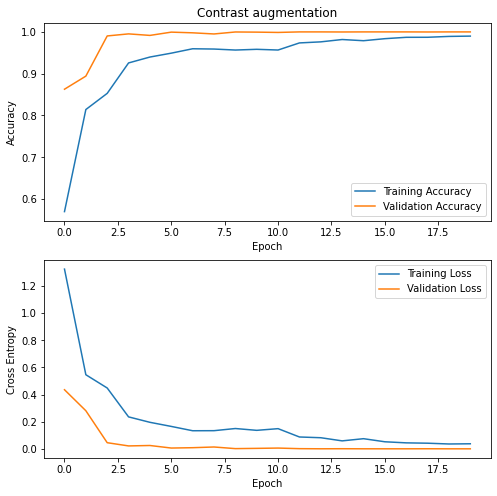

In [45]:
def plot_history(history, title_acc, title_loss, plot_name):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(title_acc)
    plt.xlabel('Epoch')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(title_loss)
    plt.xlabel('Epoch')

    plt.savefig('./%s' % plot_name)
    
plot_history(history, 'Contrast augmentation', '', 'images/contrast_dropout.png')

In [56]:
model.evaluate(X_test, y_test)

225/225 [==============================] - 2s 9ms/step - loss: 0.1188 - sparse_categorical_accuracy: 0.9808


[0.11882618069648743, 0.9807584881782532]

In [39]:
tf.keras.models.save_model(model, 'contrast_dropout.h5')

In [52]:
!ls

images	sample_images	 sign_mnist_test.csv  sign_mnist_train.csv  venv
models	sign_mnist_test  sign_mnist_train     train_model.ipynb     webcam.py
